# Лабораторная работа №1

## Задания

Самостоятельно написать код, реализующий искусственный нейрон с сигма-функцией активации, и возможность строить на его основе многослойные сети. Код должен также реализовывать градиентный спуск и обратное распространение ошибки.

На основе вашего кода:

1. Решить задачу  классификации датаcета Iris одним нейроном.
2. Решить задачу  классификации датаcета Iris одним  нейросетью из 2 слоев по 10 нейронов в слое.
3. Отрисовать разделяющую линию для обеих моделей. Сравнить метрики классификации.

## Реализация

### Библиотеки

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

### Функция активации

В качестве неё берём сигма-функцию

In [2]:
def activation(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def der_activation(x):  # производная функции активации (уже посчитан вывод)
    return x * (1 - x)

### Функция ошибок

Т.к. это задача классификации, то будет использоваться функция ошибок Categorical Cross-Entropy Loss

Её формула:

```
-sum_i(sum_j(t_ij * log(p_ij) + (1 - t_ij) * log(1 - p_ij)))
```

где

* 1 <= i <= N, N - кол-во входных данных
* 1 <= j <= C, C - кол-во классов
* t_ij - индикатор 0 или 1, что класс j является правильным для элемента i
* p_ij - предсказанная вероятность того, что у элемента i класс j
* log - логарифм
* sum_i - сумма по i
* sum_j - сумма по j

In [4]:
def loss(y_true, y_pred):
    total_sum = 0

    for i in range(y_true.shape[0]):
        value_sum = 0
        
        for j in range(y_true.shape[1]):
            p = y_pred[i][j]
            t = y_true[i][j]

            if p == 0:
                value_sum += t

            elif p == 1:
                value_sum += (1-t)

            else:
                value_sum += t * np.log(p) + (1 - t) * np.log(1 - p)
            
        total_sum += value_sum
            
    return -total_sum

In [5]:
def der_mult(y_true, y_pred):  # произведение производных функции ошибок и функции активации
    return y_pred - y_true

### One-hot transform

Предположим, для задачи классификации есть 4 возможных вывода (0, 1, 2, 3) и y выглядит так:

```
| y |
|---|
| 0 |
| 2 |
| 1 |
| 2 | 
| 3 |
| 1 |
```

Нейроны выдают значения от 0 до 1, и чтобы классификация прошла правильно, преобразуем данные в матрицу вхождений

```
| y |     |    y    |
|---|     |---------|
| 0 | --> | 1 0 0 0 |
| 2 | --> | 0 0 1 0 |
| 1 | --> | 0 1 0 0 |
| 2 | --> | 0 0 1 0 |
| 3 | --> | 0 0 0 1 |
| 1 | --> | 0 1 0 0 | 
```

In [6]:
def one_hot_transform(y, classes_count):  # преобразование в матрицу вхождений
    transformed = np.zeros((len(y), classes_count))

    for i in range(len(y)):  # исходит из предположения, что классы будут пронумерованы по порядку, начиная от 0
        transformed[i][y[i]] = 1

    return transformed

### Слой нейронной сети

Хранит матрицу весов нейронов, матрицу сдвигов нейронов, матрицу ошибок и вывод нейронов

In [7]:
class Layer:
    def __init__(self, neuron_count):
        self.neuron_count = neuron_count
        self.weights = None  # матрица весов нейронов N x W, где N - кол-во нейронов в слое, а W - кол-во входных данных в слой
        self.biases = None  # вектор сдвигов нейронов N x 1, где N - кол-во нейронов в слое
        self.output = None  # вектор вывода N x 1
        self.error = None  # вектор ошибок N x 1, нужен для обратного распространения ошибки в градиентном спуске

    
    def setup_layer(self, input_count):
        self.weights = np.zeros((self.neuron_count, input_count))

        for i in range(self.neuron_count):  # изначальные веса равны N(0, 2 / (n + w)), где n - кол-во нейронов, w - кол-во входов, N - нормальное распределение
            for j in range(input_count):
                self.weights[i][j] = np.random.normal(0, 2 / (self.neuron_count + input_count))  
                
        self.biases = np.zeros((self.neuron_count, 1))  # изначальный сдвиг равен 0

    
    def input_output(self, input_values):
        self.output = activation((self.weights @ input_values) + self.biases)  # вектор вывода, здесь F(WX + B), где X - вектор входных данных, W - матрица весов, B - вектор сдвигов
        
        return self.output

### Нейронная сеть

In [8]:
class ClassificationNetwork:
    def __init__(self, layers=[]):
        self.layers = layers
        self.mean_values = None  # модель должна хранить средние значения по данным, на которых она обучалась
        self.max_min_values = None  # модель должна хранить max - min значения по данным, на которых она обучалась


    def normalise(self, X):  # для задачи классификации с сигма-функцией лучше всего нормализовывать в пределах от -1 до 1, чтобы mean = 0, а var = 1
        normalised = np.zeros(X.shape)
    
        for i in range(normalised.shape[1]):        
            normalised[:, i] = (X[:, i] - self.mean_values[i]) / self.max_min_values[i]
    
        return normalised

    
    def back_propogation(self, true_values):  # обратное распространение ошибки
        for layer in range(len(self.layers) - 1, -1, -1):  # идём в обратном порядке, в этом суть метода
            cur_layer = self.layers[layer]
            
            if layer == len(self.layers) - 1:
                # Для выходного слоя вектор ошибок будет выглядеть так: L'(t, o) * f'(i), где:
                # L' - производная функции ошибок, f' - производная функции активации
                # o - вывод значений нынешнего слоя, t - истинный вывод, i - вывод значений предыдущего слоя
                # Важное замечание: у функции активации сигма, производная равна f(i)(1 - f(i))
                # Т.к. мы уже знаем, что o = f(i), то тогда f'(i) = o(1 - o)
                
                cur_layer.error = der_mult(true_values, cur_layer.output)

            else:
                # Для остальных слоёв вектор ошибок будет такой: TD * f'(i), где:
                # D - вектор ошибок следующего слоя, T - транспонированная матрица весов следующего слоя
                # f' - производная функции активации, o - вывод значений нынешнего слоя, i - вывод значений предыдущего слоя
                # Важное замечание: у функции активации сигма, производная равна f(i)(1 - f(i))
                # Т.к. мы уже знаем, что o = f(i), то тогда f'(i) = o(1 - o)
                
                next_layer = self.layers[layer + 1]
                cur_layer.error = (next_layer.weights.transpose() @ next_layer.error) * der_activation(cur_layer.output)
                
    
    def gradient_descent(self, input_values, learning_rate):  # градиентный спуск
        for layer in range(len(self.layers)):  # теперь идём по порядку, так называемый forward progogation     
            cur_layer = self.layers[layer]

            # Изменение сдвигов равно E*l, где l - скорость обучения, E - вектор ошибок

            delta_biases = cur_layer.error * learning_rate 

            # Изменение весов равно ET*l, где l - скорость обучения, E - вектор ошибок, T - транспонированная матрица вводных данных слоя

            delta_weights = None

            if layer == 0:
                delta_weights = (cur_layer.error @ input_values.transpose()) * learning_rate

            else:
                prev_layer = self.layers[layer - 1]
                delta_weights = (cur_layer.error @ prev_layer.output.transpose()) * learning_rate

            cur_layer.weights -= delta_weights
            cur_layer.biases -= delta_biases

        
    def fit(self, X, y, learning_rate=0.1, epochs=100, verbose=False, early_stopping=None):
        # Крайне важный шаг - мы обязаны хранить данные для нормализации, полученные от обучающих данных
        # Это необходимо, т.к. модель обучалась именно в пространстве весов (X - mean_train) / (max_train - min_train)
        # Если входные значения преобразовывать как (X - mean_test) / (max_test - min_test), то получится совсем другое пространство на котором модель не обучалась
    
        self.mean_values = X.mean(axis=0)
        self.max_min_values = X.max(axis=0) - X.min(axis=0)

        X_train = self.normalise(X)  # нормализируем данные
        y_train = one_hot_transform(y, self.layers[-1].neuron_count)  # столько классифицируем, сколько нейронов на последнем слое
        
        for layer in range(len(self.layers)):  # инициализация слоёв
            if layer == 0:
                self.layers[layer].setup_layer(len(X_train[0]))  # первый слой - входной, у него кол-во входных данных равно кол-ву вводимых атрибутов

            else:
                self.layers[layer].setup_layer(self.layers[layer-1].neuron_count)  # у каждого последующего слоя кол-во входных данных равно кол-ву нейронов на предыдущем слое

        last_error = None

        for epoch in range(epochs):  # начало обучения
            y_pred = []
            
            for value in range(len(X_train)):
                input_values = np.array([X_train[value]]).transpose()  # входные данные в виде вектор-столбца
                true_values = np.array([y_train[value]]).transpose()  # истинные данные в виде вектор-столбца
                
                neuron_output = input_values  # в первый слой идут входные данные

                for layer in range(len(self.layers)):       
                    neuron_output = self.layers[layer].input_output(neuron_output)

                y_pred.append(neuron_output.transpose()[0])  # значение последнего слоя и будет предсказанным значением
                
                self.back_propogation(true_values)  # считаем обратное распространение ошибки
                self.gradient_descent(input_values, learning_rate)  # выполняем градиентный спуск

            y_pred = np.array(y_pred)
            error = loss(y_train, y_pred)

            if verbose:
                print(f"Epoch {epoch+1} out of {epochs}, current error is {error}")

            if early_stopping is not None:  # early stopping - минимальное значение разницы ошибок последних двух итераций, меньше которого обучение останавливается
                if last_error is not None:
                    if np.abs(error - last_error) < early_stopping:
                        if verbose:
                            print("Stopping early")
                        return

                last_error = error

    
    def predict(self, X):
        X_test = self.normalise(X)
        y_pred = []  # предсказанные значения

        for value in range(len(X_test)):            
            neuron_output = np.array([X_test[value]]).transpose()  # входные данные в виде вектор-столбца

            for layer in range(len(self.layers)):    
                neuron_output = self.layers[layer].input_output(neuron_output)

            proba = neuron_output.transpose()[0] # значение последнего слоя и будет предсказанным значением - вероятности для каждого класса
            y_pred.append(np.argmax(proba))  # выбираем класс с наибольшей вероятностью

        return np.array(y_pred)  # получили предсказание


    def predict_proba(self, X):  # те же предсказания, но выведутся именно вероятности
        X_test = self.normalise(X)
        y_pred = []  # предсказанные значения

        for value in range(len(X_test)):            
            neuron_output = np.array([X_test[value]]).transpose()  # входные данные в виде вектор-столбца

            for layer in range(len(self.layers)):    
                neuron_output = self.layers[layer].input_output(neuron_output)

            y_pred.append(neuron_output.transpose()[0])

        return np.array(y_pred)  # получили предсказание

### Датасет

In [9]:
df = load_iris()
X, y = df["data"], df["target"]
classes_count = len(df["target_names"])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [11]:
y_test_proba = one_hot_transform(y_test, classes_count)

### Сеть из 1 слоя с 1 нейроном

In [12]:
model1 = ClassificationNetwork([
    Layer(1),
    Layer(classes_count)  # кол-во нейронов на выходном слою равно кол-ву типов классификации
])

In [13]:
model1.fit(X_train, y_train, epochs=100)

In [14]:
y_pred1 = model1.predict(X_test)

In [15]:
y_pred_proba1 = model1.predict_proba(X_test)

### Сеть из 2 слоёв по 10 нейронов

In [16]:
model2 = ClassificationNetwork([
    Layer(10),
    Layer(10),
    Layer(classes_count)  # кол-во нейронов на выходном слою равно кол-ву типов классификации
])

In [17]:
model2.fit(X_train, y_train, epochs=100)

In [18]:
y_pred2 = model2.predict(X_test)

In [19]:
y_pred_proba2 = model2.predict_proba(X_test)

### Метрики модели 1

In [20]:
accuracy_score(y_test, y_pred1)

0.9333333333333333

In [21]:
precision_score(y_test, y_pred1, average="macro")

0.9444444444444445

In [22]:
recall_score(y_test, y_pred1, average="macro")

0.9333333333333332

In [23]:
f1_score(y_test, y_pred1, average="macro")

0.9326599326599326

In [24]:
roc_auc_score(y_test_proba, y_pred_proba1)

0.8333333333333334

### Метрики модели 2

In [25]:
accuracy_score(y_test, y_pred2)

0.9666666666666667

In [26]:
precision_score(y_test, y_pred2, average="macro")

0.9696969696969697

In [27]:
recall_score(y_test, y_pred2, average="macro")

0.9666666666666667

In [28]:
f1_score(y_test, y_pred2, average="macro")

0.9665831244778612

In [29]:
roc_auc_score(y_test_proba, y_pred_proba2)

1.0

Главная метрика на которую стоит обратить внимание - roc_auc_score. По сути она показывает, насколько хорошо модель может именно различать классы, а не полагаться порог классификации (в моём случае - это выбор максимального по вероятности значения).

Исходя из неё видно, что 2 модель гораздо лучше справляется с классификацией, нежели первая модель, которая сильнее зависит от порога классификации

### Отрисовка разделяющих линий

In [30]:
def plot_separation(X_test, y_test, model, feature1, feature2, width=200, height=200):  
    # Создаём сетку точек для визуализации

    x_min, x_max = X_test[:, feature1].min() - 0.1, X_test[:, feature1].max() + 0.1
    y_min, y_max = X_test[:, feature2].min() - 0.1, X_test[:, feature2].max() + 0.1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, width), np.linspace(y_min, y_max, height))

    grid = np.zeros((width*height, X_test.shape[1]))  # матрица значений весов сетки

    for i in range(X_test.shape[1]):
        if i == feature1:
            grid[:, i] = xx.ravel()

        elif i == feature2:
            grid[:, i] = yy.ravel()

        else:
            grid[:, i].fill(X_test[:, i].mean())  # признаки, которые игнорируем, заменяем их средним значением, но не удаляем, а то модель не сможет обучаться

    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)  # окрашиваем области классов
    plt.scatter(X_test[:, feature1], X_test[:, feature2], c=y_test, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.xlabel(f"Feature {feature1}")
    plt.ylabel(f"Feature {feature2}")
    plt.show()    

Признаки, которые рассматриваем

In [31]:
target_feature1 = 2
target_feature2 = 3

Разрешение картинки в точках

In [32]:
width = 500
height = 500

### Разделяющие линии модели 1

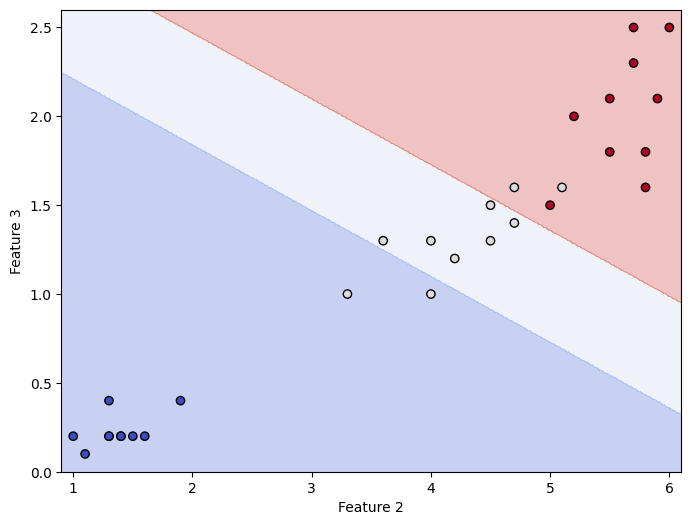

In [33]:
plot_separation(X_test, y_test, model1, target_feature1, target_feature2, width, height)

### Разделяющие линии модели 2

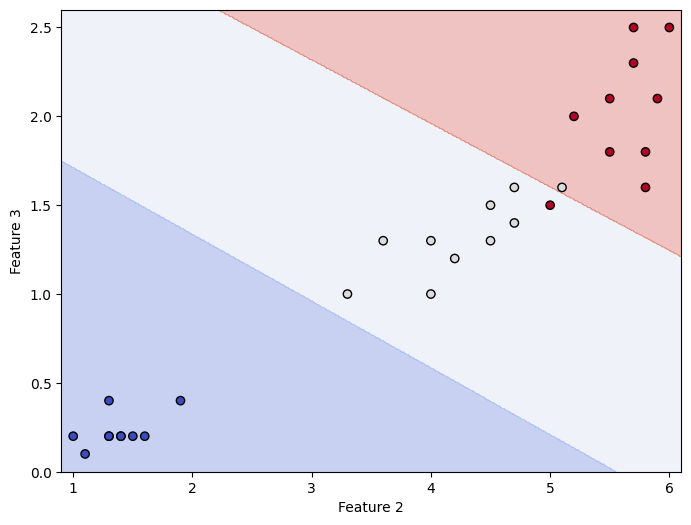

In [34]:
plot_separation(X_test, y_test, model2, target_feature1, target_feature2, width, height)